In [17]:
#best with 90 accuracy
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from traitlets import validate
import sklearn.model_selection
import numpy as np
import tensorflow as tf
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [18]:
data_dir = r"C:\Users\B.BASI REDDY\Documents\TB_Chest_Radiography_Database\Normal"
data_dir2 = r"C:\Users\B.BASI REDDY\Documents\TB_Chest_Radiography_Database\Tuberculosis"
img2 = os.listdir(data_dir2)
images = os.listdir(data_dir)

In [19]:
data = pd.DataFrame({
    'image_path':[os.path.join(data_dir, filename) for filename in images] + [os.path.join(data_dir2, filename) for filename in img2],
    'class' :["NORMAL"]* len(images) + ["TUBERCOLOSIS"]* len(img2)
})

In [20]:
data


,image_path,class
0,C:\Users\B.BASI REDDY\Documents\TB_Chest_Radio...,NORMAL
1,C:\Users\B.BASI REDDY\Documents\TB_Chest_Radio...,NORMAL
2,C:\Users\B.BASI REDDY\Documents\TB_Chest_Radio...,NORMAL
3,C:\Users\B.BASI REDDY\Documents\TB_Chest_Radio...,NORMAL
4,C:\Users\B.BASI REDDY\Documents\TB_Chest_Radio...,NORMAL
...,...,...
75,C:\Users\B.BASI REDDY\Documents\TB_Chest_Radio...,TUBERCOLOSIS
76,C:\Users\B.BASI REDDY\Documents\TB_Chest_Radio...,TUBERCOLOSIS
77,C:\Users\B.BASI REDDY\Documents\TB_Chest_Radio...,TUBERCOLOSIS
78,C:\Users\B.BASI REDDY\Documents\TB_Chest_Radio...,TUBERCOLOSIS


In [21]:
import random

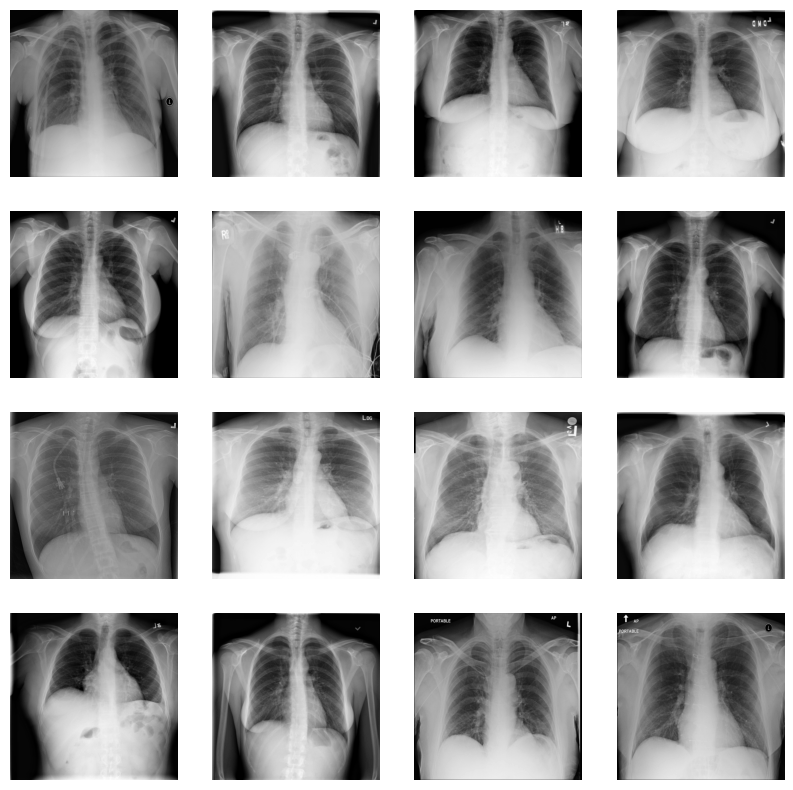

In [22]:
fig, axs = plt.subplots(4,4, figsize=(10,10))

for idx, ax in enumerate(axs.ravel()):
#     random_idx = random.randint(0,len(data)-1)
    img = cv2.imread(data.iloc[idx]['image_path'], cv2.IMREAD_GRAYSCALE)
    
    ax.imshow(img, cmap= 'gray')
    ax.axis('off')
    
plt.show()

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
image_size = (128, 128)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    data,
    x_col='image_path',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    subset='training'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

validation_generator = validation_datagen.flow_from_dataframe(
    data,
    x_col='image_path',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    subset='validation'
)

Found 64 validated image filenames belonging to 2 classes.
Found 0 validated image filenames belonging to 2 classes.


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [25]:
model = Sequential([
    Conv2D(32,(3,3), activation='relu',input_shape=(128,128,1)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
from tensorflow.keras.callbacks import Callback

In [27]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch,logs=None):
        if logs.get('accuracy')>0.8:
            self.model.stop_training =True
            
custom_callback = CustomCallback()

In [28]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[custom_callback]
)

Epoch 1/50
2/2 [==============================] - 2s 526ms/step - loss: 1.5363 - accuracy: 0.6250
Epoch 2/50
2/2 [==============================] - 1s 563ms/step - loss: 0.7221 - accuracy: 0.5938
Epoch 3/50
2/2 [==============================] - 1s 475ms/step - loss: 0.6982 - accuracy: 0.5312
Epoch 4/50
2/2 [==============================] - 1s 470ms/step - loss: 0.6491 - accuracy: 0.6250
Epoch 5/50
2/2 [==============================] - 1s 467ms/step - loss: 0.6379 - accuracy: 0.6250
Epoch 6/50
2/2 [==============================] - 1s 498ms/step - loss: 0.5634 - accuracy: 0.7188
Epoch 7/50
2/2 [==============================] - 1s 476ms/step - loss: 0.5373 - accuracy: 0.7969
Epoch 8/50
2/2 [==============================] - 1s 500ms/step - loss: 0.4732 - accuracy: 0.7969
Epoch 9/50
2/2 [==============================] - 1s 530ms/step - loss: 0.4377 - accuracy: 0.7969
Epoch 10/50
2/2 [==============================] - 1s 552ms/step - loss: 0.4508 - accuracy: 0.8125


1/1 [==============================] - 0s 96ms/step


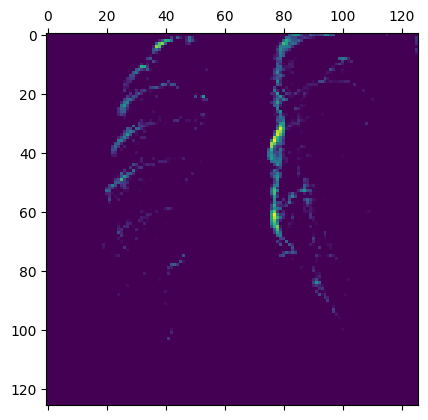

In [29]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

img_path = r"C:\Users\B.BASI REDDY\Documents\TB_Chest_Radiography_Database\Tuberculosis\Tuberculosis-2.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, image_size)
img = np.expand_dims(img, axis=0)

activations = activation_model.predict(img)
first_layer_activation = activations[0]

plt.matshow(first_layer_activation[0, :, :, -1], cmap='viridis')
plt.show()

1/1 [==============================] - 0s 32ms/step


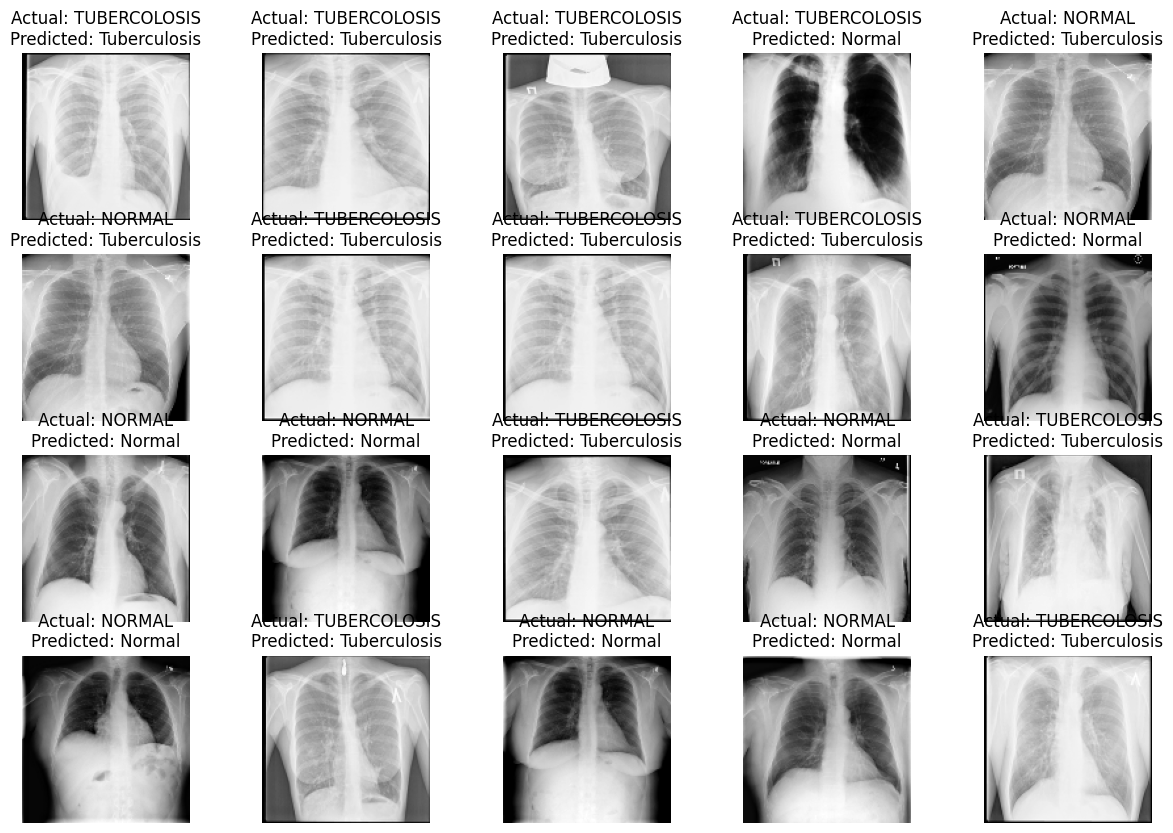

In [30]:
plt.figure(figsize=(15, 10))

for i in range(20):
    random_idx = random.randint(0, len(data) - 1)
    img_path = data['image_path'][random_idx]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, image_size)
    img = np.expand_dims(img, axis=0)
    actual_class = data['class'][random_idx]
    predicted_class = "Tuberculosis" if model.predict(img) > 0.5 else "Normal"

    plt.subplot(4, 5, i + 1)
    plt.imshow(img[0], cmap='gray')
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
    plt.axis('off')

plt.show()


KeyError: 'val_accuracy'

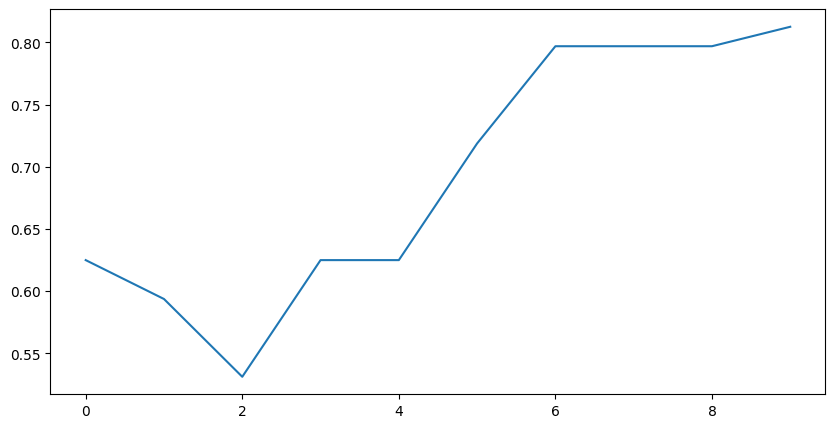

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
accuracy = (confusion[0, 0] + confusion[1, 1]) / np.sum(confusion)

print(f'Accuracy: {accuracy:.2%}')